In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm
import datasets

/home/lijiahao/miniconda3/envs/mars-atmos/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### forward

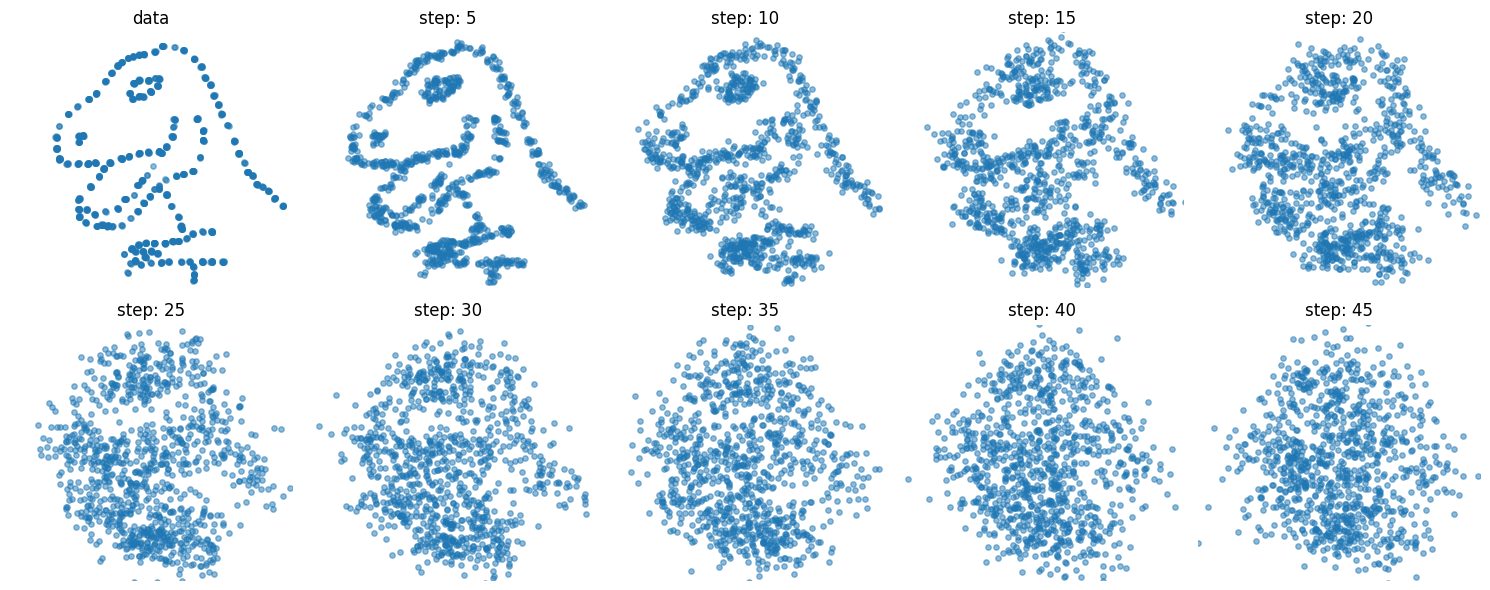

In [3]:
num_timesteps = 50
plot_step = 5

num_plots = math.ceil(num_timesteps / plot_step)
num_cols = 5
num_rows = math.ceil(num_plots / num_cols)

fig = plt.figure(figsize=(15, 6))

noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
dataset = datasets.get_dataset("dino", n=1000)
x0 = dataset.tensors[0]

plt_cnt = 1
plt.subplot(num_rows, num_cols, plt_cnt)
plt.scatter(x0[:, 0], x0[:, 1], alpha=0.5, s=15)
plt.title("data")
plt.xlim(-3.5, 3.5)
plt.ylim(-4., 4.75)
plt.axis("off")
        
for t in range(len(noise_scheduler)):
    timesteps = np.repeat(t, len(x0))
    noise = torch.randn_like(x0)
    sample = noise_scheduler.add_noise(x0, noise, timesteps)
    if (t + 1) % plot_step == 0 and (t + 1) != len(noise_scheduler):
        plt_cnt += 1
        plt.subplot(num_rows, num_cols, plt_cnt)
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
        plt.title(f"step: {t + 1}")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4., 4.75)
        plt.axis("off")
        
fig.tight_layout()
plt.savefig("static/forward.png", facecolor="white")
plt.show()

### reverse

In [4]:
!python ddpm.py --experiment_name dino_base

Training model...
100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 125.65it/s]
Saving model...
Saving images...
Saving loss as numpy array...
Saving frames...


In [5]:
model = ddpm.MLP()

path = "exps/dino_base/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

MLP(
  (time_mlp): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (input_mlp1): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (input_mlp2): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (joint_mlp): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): GELU(approximate=none)
    (2): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate=none)
    )
    (3): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate=none)
    )
    (4): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate=none)
    )
    (5): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [6]:
eval_batch_size = 1000
num_timesteps = 50
plot_step = 5
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 2)
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.numpy())
        steps.append(i + 1)

100%|██████████| 50/50 [00:00<00:00, 237.29it/s]


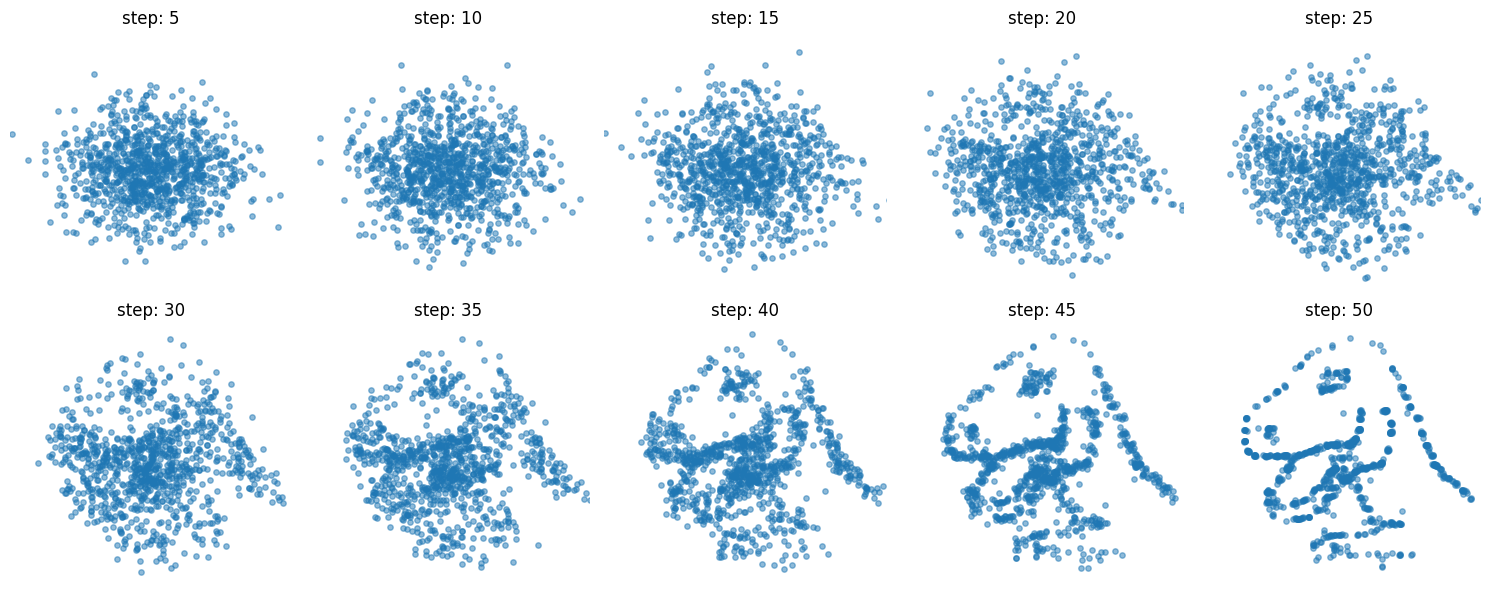

In [7]:
num_cols = 5
num_rows = math.ceil(len(samples) / num_cols)
fig = plt.figure(figsize=(15, 6))
for i, sample in enumerate(samples):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
    plt.title(f"step: {steps[i]}")
    plt.xlim(-3.5, 3.5)
    plt.ylim(-4., 4.75)
    plt.axis("off")
fig.tight_layout()
plt.savefig("static/reverse.png", facecolor="white")
plt.show()

## ablations

In [8]:
def plot_ablation(frames_dict, outname):
    num_rows = len(frames_dict)
    num_cols = 10

    fig = plt.figure(figsize=(3.5*num_cols, 3*num_rows + 0.5))
    row = 0

    for name, frames in frames_dict.items():
        epoch_step = len(frames) // num_cols
        offset = row*(num_cols + 1)
        plt.subplot(num_rows, num_cols + 1, offset + 1)
        plt.scatter(0, 0, alpha=0)
        plt.text(0, 0, name, fontdict={"size": 30})
        plt.xlim(-0.25, 2)
        plt.axis("off")

        for i in range(num_cols):
            plt.subplot(num_rows, num_cols + 1, offset + i + 2)
            ix = i * epoch_step
            frame = frames[ix]
            plt.scatter(frame[:, 0], frame[:, 1], s=5, alpha=0.7)
            if row == 0:
                if i == 0:
                    title = f"epoch {ix}"
                else:
                    title = f"{ix}"
                plt.title(title, fontdict={"size": 30}, pad=30)
            plt.xlim(-3.5, 3.5)
            plt.ylim(-4., 4.75)
            plt.axis("off")

        row += 1

    plt.tight_layout()
    plt.savefig(outname, facecolor="white")
    plt.show()

### datasets

In [ ]:
!python ddpm.py --dataset moons --experiment_name moons_base
!python ddpm.py --dataset dino --experiment_name dino_base
!python ddpm.py --dataset line --experiment_name line_base
!python ddpm.py --dataset circle --experiment_name circle_base

In [ ]:
frames_dict = {
    "moons": np.load("exps/moons_base/frames.npy"),
    "dino": np.load("exps/dino_base/frames.npy"),
    "line": np.load("exps/line_base/frames.npy"),
    "circle": np.load("exps/circle_base/frames.npy"),
}

plot_ablation(frames_dict, "static/datasets.png")

### learning rate

In [ ]:
!python ddpm.py --learning_rate 1e-2 --experiment_name dino_lr1e-2
!python ddpm.py --learning_rate 1e-3 --experiment_name dino_lr1e-3
!python ddpm.py --learning_rate 1e-4 --experiment_name dino_lr1e-4
!python ddpm.py --learning_rate 1e-5 --experiment_name dino_lr1e-5

In [ ]:
frames_dict = {
    "lr 1e-2": np.load("exps/dino_lr1e-2/frames.npy"),
    "lr 1e-3": np.load("exps/dino_lr1e-3/frames.npy"),
    "lr 1e-4": np.load("exps/dino_lr1e-4/frames.npy"),
    "lr 1e-5": np.load("exps/dino_lr1e-5/frames.npy"),
}

plot_ablation(frames_dict, "static/learning_rate.png")

### num_timesteps

In [ ]:
!python ddpm.py --num_timesteps 5 --experiment_name dino_timesteps5
!python ddpm.py --num_timesteps 10 --experiment_name dino_timesteps10
!python ddpm.py --num_timesteps 25 --experiment_name dino_timesteps25
!python ddpm.py --num_timesteps 50 --experiment_name dino_timesteps50
!python ddpm.py --num_timesteps 100 --experiment_name dino_timesteps100
!python ddpm.py --num_timesteps 250 --experiment_name dino_timesteps250

In [ ]:
frames_dict = {
    "        5": np.load("exps/dino_timesteps5/frames.npy"),
    "       10": np.load("exps/dino_timesteps10/frames.npy"),
    "       25": np.load("exps/dino_timesteps25/frames.npy"),
    "       50": np.load("exps/dino_timesteps50/frames.npy"),
    "      100": np.load("exps/dino_timesteps100/frames.npy"),
    "      250": np.load("exps/dino_timesteps250/frames.npy"),
}

plot_ablation(frames_dict, "static/num_timesteps.png")

### beta schedule

In [ ]:
!python ddpm.py --beta_schedule quadratic --experiment_name dino_quadratic_schedule

In [ ]:
frames_dict = {
    "linear": np.load("exps/dino_base/frames.npy"),
    "quadratic": np.load("exps/dino_quadratic_schedule/frames.npy"),
}

plot_ablation(frames_dict, "static/beta_schedule.png")

### hidden size

In [ ]:
!python ddpm.py --hidden_size 16 --experiment_name dino_hid_size_16
!python ddpm.py --hidden_size 32 --experiment_name dino_hid_size_32
!python ddpm.py --hidden_size 64 --experiment_name dino_hid_size_64
!python ddpm.py --hidden_size 256 --experiment_name dino_hid_size_256
!python ddpm.py --hidden_size 512 --experiment_name dino_hid_size_512

In [ ]:
frames_dict = {
    "       16": np.load("exps/dino_hid_size_16/frames.npy"),
    "       32": np.load("exps/dino_hid_size_32/frames.npy"),
    "       64": np.load("exps/dino_hid_size_64/frames.npy"),
    "      128": np.load("exps/dino_base/frames.npy"),
    "      256": np.load("exps/dino_hid_size_256/frames.npy"),
    "      512": np.load("exps/dino_hid_size_512/frames.npy"),
}

plot_ablation(frames_dict, "static/hidden_size.png")

### num layers

In [ ]:
!python ddpm.py --hidden_layers 1 --experiment_name dino_hid_layers_1
!python ddpm.py --hidden_layers 2 --experiment_name dino_hid_layers_2
!python ddpm.py --hidden_layers 4 --experiment_name dino_hid_layers_4
!python ddpm.py --hidden_layers 5 --experiment_name dino_hid_layers_5

In [ ]:
frames_dict = {
    "        1": np.load("exps/dino_hid_layers_1/frames.npy"),
    "        2": np.load("exps/dino_hid_layers_2/frames.npy"),
    "        3": np.load("exps/dino_base/frames.npy"),
    "        4": np.load("exps/dino_hid_layers_4/frames.npy"),
    "        5": np.load("exps/dino_hid_layers_5/frames.npy"),
    
}

plot_ablation(frames_dict, "static/num_hidden_layers.png")

### positional embedding (timestep)

In [ ]:
!python ddpm.py --time_embedding learnable --experiment_name dino_time_emb_learnable
!python ddpm.py --time_embedding linear --experiment_name dino_time_emb_linear
!python ddpm.py --time_embedding zero --experiment_name dino_time_emb_zeros

In [ ]:
frames_dict = {
    "learnable": np.load("exps/dino_time_emb_learnable/frames.npy"),
    "sinusoidal": np.load("exps/dino_base/frames.npy"),
    "linear": np.load("exps/dino_time_emb_linear/frames.npy"),
    "zero": np.load("exps/dino_time_emb_zeros/frames.npy"),
}

plot_ablation(frames_dict, "static/time_embedding.png")

### positional embedding (inputs)

In [ ]:
!python ddpm.py --input_embedding learnable --experiment_name dino_input_emb_learnable
!python ddpm.py --input_embedding linear --experiment_name dino_input_emb_linear
!python ddpm.py --input_embedding identity --experiment_name dino_input_emb_identity

In [ ]:
frames_dict = {
    "learnable": np.load("exps/dino_input_emb_learnable/frames.npy"),
    "sinusoidal": np.load("exps/dino_base/frames.npy"),
    "linear": np.load("exps/dino_input_emb_linear/frames.npy"),
    "identity": np.load("exps/dino_input_emb_identity/frames.npy"),
}

plot_ablation(frames_dict, "static/input_embedding.png")

### forward and reverse process animation

In [ ]:
from celluloid import Camera

In [ ]:
num_timesteps = 250
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)

model = ddpm.MLP()
path = "exps/dino_timesteps250/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

dataset = datasets.get_dataset("dino", n=1000)
x0 = dataset.tensors[0]

In [ ]:
forward_samples = []
forward_samples.append(x0)
for t in range(len(noise_scheduler)):
    timesteps = np.repeat(t, len(x0))
    noise = torch.randn_like(x0)
    sample = noise_scheduler.add_noise(x0, noise, timesteps)
    forward_samples.append(sample)

In [ ]:
eval_batch_size = len(dataset)
sample = torch.randn(eval_batch_size, 2)
timesteps = list(range(num_timesteps))[::-1]
reverse_samples = []
reverse_samples.append(sample.numpy())
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    reverse_samples.append(sample.numpy())

In [ ]:
xmin, xmax = -3.5, 3.5
ymin, ymax = -4., 4.75

fig, ax = plt.subplots()
camera = Camera(fig)

# forward
for i, sample in enumerate(forward_samples):
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15, color="blue")
    ax.text(0.0, 0.95, f"step {i: 4} / {num_timesteps}", transform=ax.transAxes)
    ax.text(0.0, 1.01, "Forward process", transform=ax.transAxes, size=15)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.axis("off")
    camera.snap()
        
# reverse
for i, sample in enumerate(reverse_samples):
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15, color="blue")
    ax.text(0.0, 0.95, f"step {i: 4} / {num_timesteps}", transform=ax.transAxes)
    ax.text(0.0, 1.01, "Reverse process", transform=ax.transAxes, size=15)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.axis("off")
    camera.snap()
    
animation = camera.animate(blit=True, interval=35)
animation.save("static/animation.mp4")